In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
file_path = "/content/TOP_PRODUCT_2_SENTIMENT_SMOOTHED.csv"
df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16859 entries, 0 to 16858
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       16859 non-null  int64  
 1   Id                 16859 non-null  int64  
 2   roberta_neg        16859 non-null  float64
 3   roberta_neu        16859 non-null  float64
 4   roberta_pos        16859 non-null  float64
 5   Unnamed: 0         16859 non-null  int64  
 6   timestamp          16859 non-null  object 
 7   rating             16859 non-null  float64
 8   title              16849 non-null  object 
 9   text               16847 non-null  object 
 10  parent_asin        16859 non-null  object 
 11  verified_purchase  16859 non-null  bool   
 12  smoothed           16859 non-null  float64
 13  smoothed_neg       16859 non-null  float64
 14  smoothed_neu       16859 non-null  float64
dtypes: bool(1), float64(7), int64(3), object(4)
memory usage: 1.8+ MB


In [3]:
df.head()

,Unnamed: 0.1,Id,roberta_neg,roberta_neu,roberta_pos,Unnamed: 0,timestamp,rating,title,text,parent_asin,verified_purchase,smoothed,smoothed_neg,smoothed_neu
0,11566,11567,0.001923,0.027694,0.970383,3547385,2018-05-11 17:21:49,4.0,Four Stars,Easy to use. Non invasive. Vibrates with resul...,B075QQ8VZW,True,0.970383,0.001923,0.027694
1,15082,15083,0.001951,0.032199,0.965850,5147804,2018-05-12 18:36:23,5.0,This is the easiest and quickest thermometer I...,I've only had this thermometer for a week and ...,B075QQ8VZW,True,0.968116,0.001937,0.029946
2,1903,1904,0.005065,0.083532,0.911403,741656,2018-05-13 00:28:58,5.0,Five Stars,Easy to use. Easy to read display. Light weigh...,B075QQ8VZW,True,0.949212,0.002980,0.047808
3,15180,15181,0.268450,0.494306,0.237244,5197730,2018-05-24 16:19:08,4.0,I like the thermometer,I like the thermometer. It is easier to use th...,B075QQ8VZW,True,0.771220,0.069347,0.159433
4,15771,15772,0.350157,0.382552,0.267292,5511982,2018-05-24 17:02:23,4.0,"Great Value, Accurrate, and Easy to Use",My only complaint is that it does not work wit...,B075QQ8VZW,True,0.670434,0.125509,0.204057


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16859 entries, 0 to 16858
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0.1       16859 non-null  int64         
 1   Id                 16859 non-null  int64         
 2   roberta_neg        16859 non-null  float64       
 3   roberta_neu        16859 non-null  float64       
 4   roberta_pos        16859 non-null  float64       
 5   Unnamed: 0         16859 non-null  int64         
 6   timestamp          16859 non-null  datetime64[ns]
 7   rating             16859 non-null  float64       
 8   title              16849 non-null  object        
 9   text               16847 non-null  object        
 10  parent_asin        16859 non-null  object        
 11  verified_purchase  16859 non-null  bool          
 12  smoothed           16859 non-null  float64       
 13  smoothed_neg       16859 non-null  float64       
 14  smoothed_ne

# Neutral Sentiment

In [6]:
data = df[['timestamp', 'smoothed_neu']].set_index('timestamp')

In [14]:
data

,smoothed_neu
timestamp,
2018-05-11 17:21:49,0.027694
2018-05-12 18:36:23,0.029946
2018-05-13 00:28:58,0.047808
2018-05-24 16:19:08,0.159433
2018-05-24 17:02:23,0.204057
...,...
2023-08-29 18:54:05,0.257669
2023-08-30 18:12:48,0.337531
2023-09-05 12:28:50,0.335340


In [7]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [8]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

In [9]:
SEQ_LENGTH = 30

X, y = create_sequences(data_scaled, SEQ_LENGTH)


train_ratio = 0.8
val_ratio = 0.05

train_index = int(train_ratio * len(X))
val_index = int((train_ratio + val_ratio) * len(X))

X_train, X_val, X_test = X[:train_index], X[train_index:val_index], X[val_index:]
y_train, y_val, y_test = y[:train_index], y[train_index:val_index], y[val_index:]

In [ ]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (13463, 30, 1), y_train: (13463, 1)
X_val: (841, 30, 1), y_val: (841, 1)
X_test: (2525, 30, 1), y_test: (2525, 1)


In [19]:
y_test[0]

array([0.33565405])

In [ ]:
SEQ_LENGTH = 30

In [ ]:
# LSTM Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0247 - val_loss: 0.0037
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 9/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 11/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 12/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

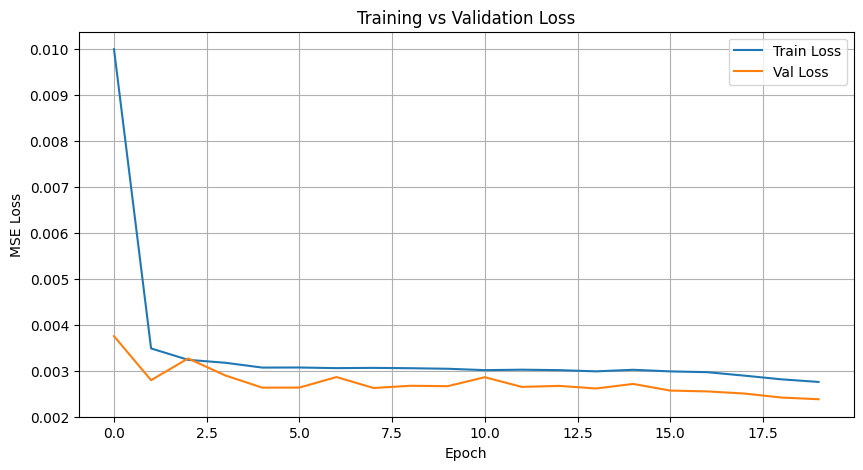

In [ ]:
# Plot train vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_actual, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test_actual, y_pred)

r2 = r2_score(y_test_actual, y_pred)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")


RMSE: 0.026558519532952376
MSE: 0.000705354959782213
MAE: 0.020398190133863753
R² Score: 0.8441715993390846


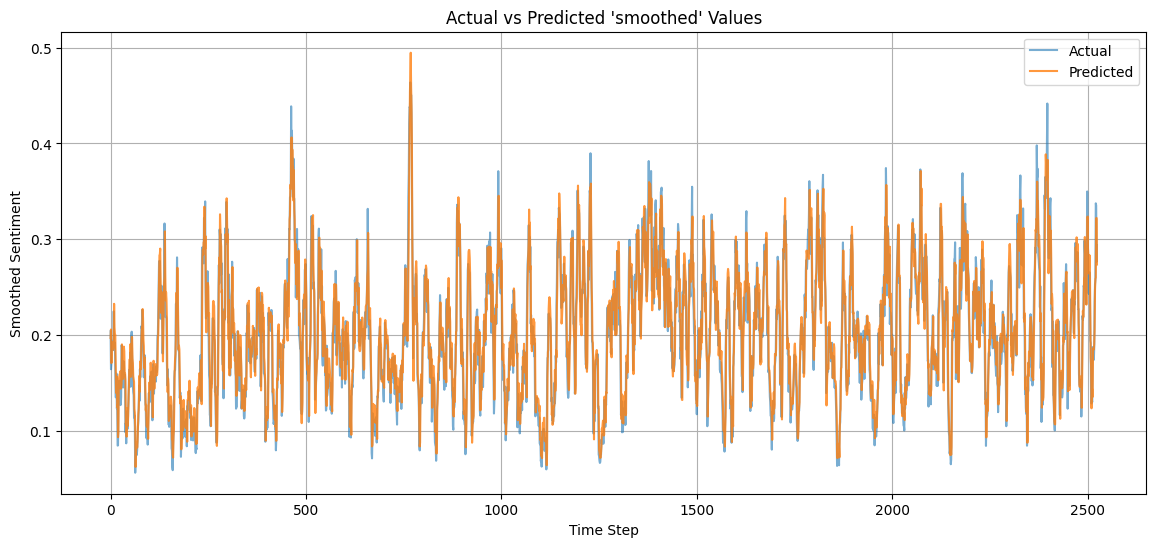

In [ ]:
# Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label="Actual", alpha=0.6)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.title("Actual vs Predicted 'smoothed' Values")
plt.xlabel("Time Step")
plt.ylabel("Smoothed Sentiment")
plt.legend()
plt.grid(True)
plt.show()

# Positive Sentiment

X_train: (13463, 30, 1), y_train: (13463, 1)
X_val: (841, 30, 1), y_val: (841, 1)
X_test: (2525, 30, 1), y_test: (2525, 1)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0535 - val_loss: 0.0044
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 9/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 11/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 12/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0

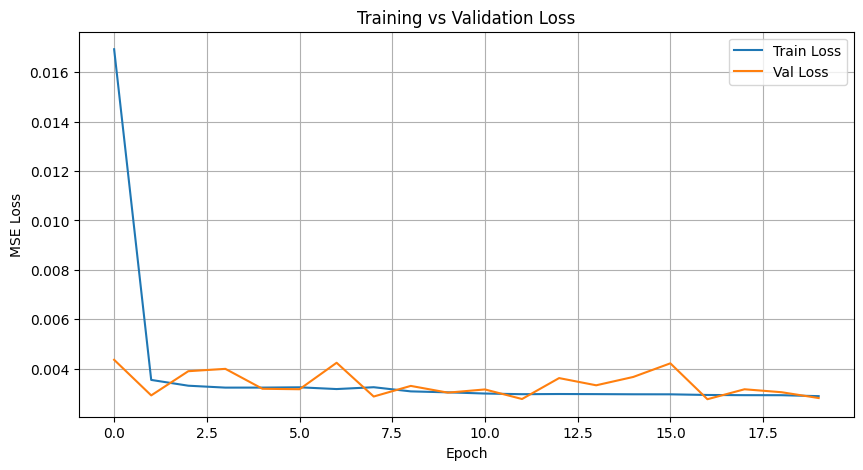

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 0.05364231387872571
MSE: 0.0028774978382637285
MAE: 0.043614715218488684
R² Score: 0.8533781738799417


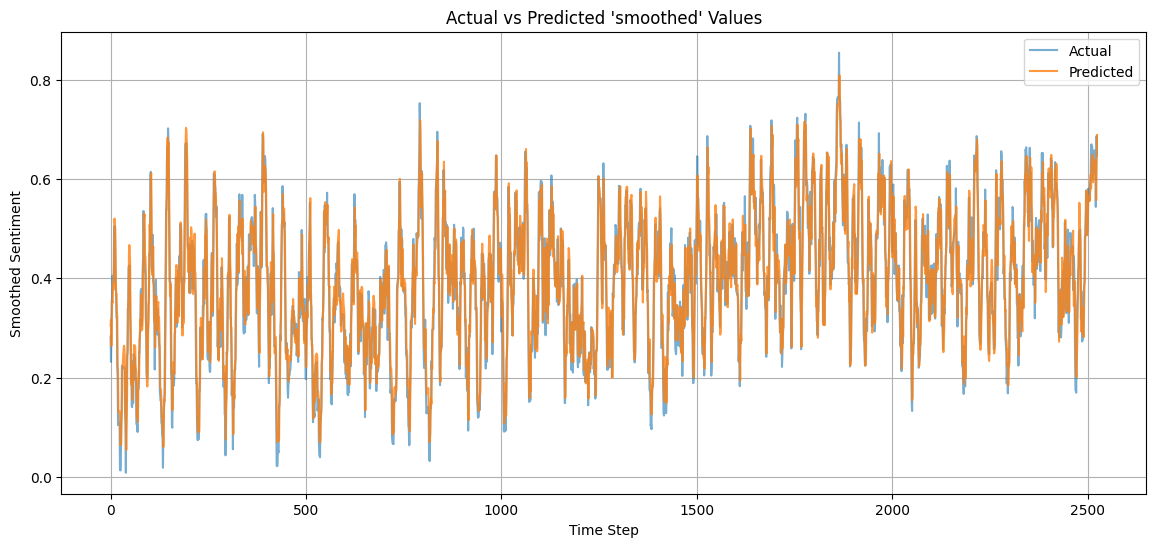

In [ ]:
data = df[['timestamp', 'smoothed']].set_index('timestamp')
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 30

X, y = create_sequences(data_scaled, SEQ_LENGTH)


train_ratio = 0.8
val_ratio = 0.05

train_index = int(train_ratio * len(X))
val_index = int((train_ratio + val_ratio) * len(X))

X_train, X_val, X_test = X[:train_index], X[train_index:val_index], X[val_index:]
y_train, y_val, y_test = y[:train_index], y[train_index:val_index], y[val_index:]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


# LSTM Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


# Plot train vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_actual, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test_actual, y_pred)

r2 = r2_score(y_test_actual, y_pred)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")


# Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label="Actual", alpha=0.6)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.title("Actual vs Predicted 'smoothed' Values")
plt.xlabel("Time Step")
plt.ylabel("Smoothed Sentiment")
plt.legend()
plt.grid(True)
plt.show()


# Negative Sentiment

X_train: (13463, 30, 1), y_train: (13463, 1)
X_val: (841, 30, 1), y_val: (841, 1)
X_test: (2525, 30, 1), y_test: (2525, 1)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0123 - val_loss: 0.0045
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 9/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 10/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 11/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 12/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.

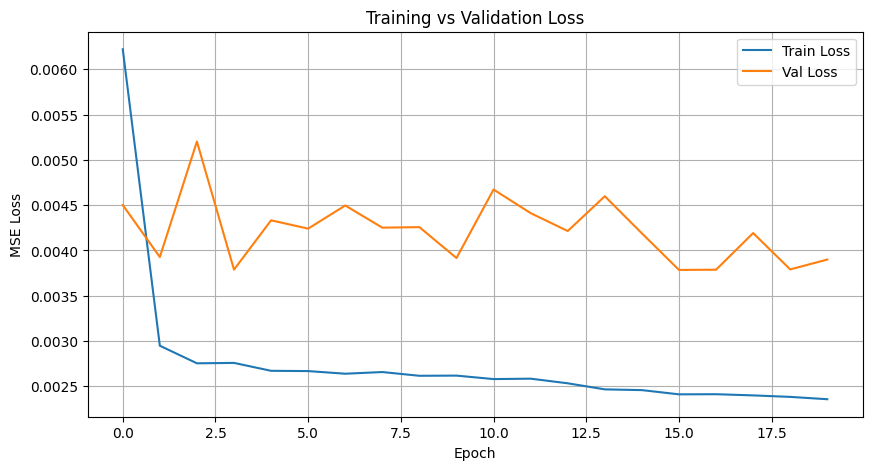

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 0.05259449951749394
MSE: 0.0027661813794956705
MAE: 0.04255799041730398
R² Score: 0.8680188908591084


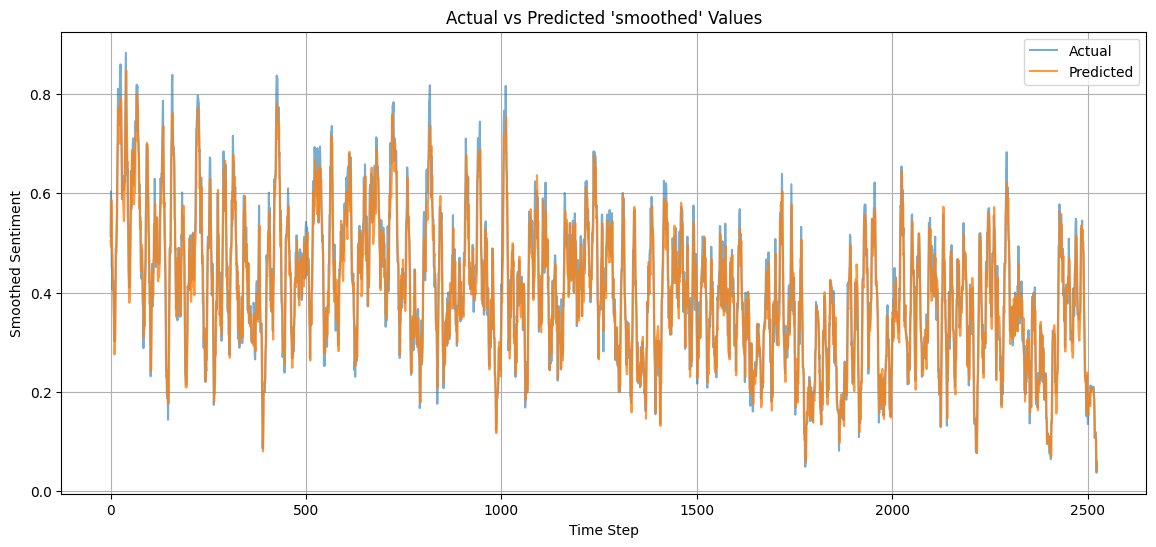

In [ ]:
data = df[['timestamp', 'smoothed_neg']].set_index('timestamp')
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 30

X, y = create_sequences(data_scaled, SEQ_LENGTH)


train_ratio = 0.8
val_ratio = 0.05

train_index = int(train_ratio * len(X))
val_index = int((train_ratio + val_ratio) * len(X))

X_train, X_val, X_test = X[:train_index], X[train_index:val_index], X[val_index:]
y_train, y_val, y_test = y[:train_index], y[train_index:val_index], y[val_index:]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


# LSTM Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


# Plot train vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_actual, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test_actual, y_pred)

r2 = r2_score(y_test_actual, y_pred)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")


# Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label="Actual", alpha=0.6)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.title("Actual vs Predicted 'smoothed' Values")
plt.xlabel("Time Step")
plt.ylabel("Smoothed Sentiment")
plt.legend()
plt.grid(True)
plt.show()
